# 项目描述

通过二手房信息，对数据进行进一步清洗处理，分析各维度的数据，筛选对房价有显著影响的特征变量，二手房整体情况、价格情况和价格的影响因素，建立房价预测模型。

- 探究单价、数量、总价和行政区域之间的关系
- 探究其它因素和总价的关系
- 户型分布
- 分析建筑年代情况
- 使用机器学习模型建立回归分析模型进行价格预测

#  数据分析

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
import numpy as np

#总体有多少封正常邮件，多少封垃圾邮件
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from pyecharts.charts import *
from pyecharts import options as opts
from pyecharts.faker import Faker
from pyecharts.render import make_snapshot
# 使用 snapshot-selenium 渲染图片
from snapshot_selenium import snapshot

import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.commons.utils import JsCode
from pyecharts.globals import ThemeType

In [2]:
# 1. 导入数据
df = pd.read_csv('house.csv', encoding='gbk')

In [3]:
# 2. 查看数据情况

## 1）数据总体情况
print(f'样本量共有 {df.shape[0]} 个')

样本量共有 8942 个


In [4]:
## 2) 判断是否有重复项
df.duplicated().sum()

2329

In [5]:
## 3) 判断是否有缺失值
df.isnull().sum()

户型         0
建筑面积       0
朝向         0
楼层         0
装修         0
建筑年代    2081
电梯      1859
产权性质    1859
住宅类别    2825
建筑结构    3862
建筑类别    2496
区域         0
学校         0
总价         0
单价         0
dtype: int64

In [6]:
## 4) 查看数据类型
df.dtypes

户型       object
建筑面积     object
朝向       object
楼层       object
装修       object
建筑年代     object
电梯       object
产权性质     object
住宅类别     object
建筑结构     object
建筑类别     object
区域       object
学校        int64
总价      float64
单价       object
dtype: object

In [7]:
## 4) 唯一标签值
print(df['朝向'].unique())
print(df['楼层'].unique())
print(df['装修'].unique())
print(df['产权性质'].unique())
print(df['住宅类别'].unique())
print(df['建筑结构'].unique())
print(df['建筑类别'].unique())
print(df['区域'].unique())
print(df['建筑年代'].unique())

['南' '南北' '西北' '东西' '东南' '北' '西南' '东北' '东' '西' '暂无']
['高层' '中层' '低层' '中楼层' '低楼层' '高楼层' '暂无']
['毛坯' '简装修' '暂无' '精装修' '中装修' '豪华装修']
['商品房' '房改房' nan '个人产权' '商品房(免税)' '普通商品房' '经济适用房' '房本房' '限价房']
['普通住宅' nan '经济适用房' '公寓' '商住楼' '酒店式公寓']
['平层' nan '开间' '跃层' '错层' '复式']
['板楼' nan '钢混' '塔板结合' '砖混' '平房' '塔楼' '砖楼']
['城关' '安宁' '七里河' '七里河区' '西固' '榆中' '城关区' '新区' '红古' '安宁区' '西固区' '永登' '榆中县'
 '皋兰' '永登区' '榆中区' '红古区']
['2020年' nan '2015年' '2014年' '2008年' '2004年' '2003年' '2017年' '2000年'
 '2012年' '2021年' '2016年' '2005年' '2007年' '2009年' '2011年' '2006年' '2002年'
 '1995年' '2010年' '1998年' '2013年' '1999年' '2001年' '2022年' '1900-01-01年'
 '1990年' '2018年' '2019年' '1989年' '2005-05-08年' '1996年' '1993年' '1992年'
 '1997年' '2006-01-01年' '2010-07-30年' '2004-05-27年' '2014-03-15年'
 '2010-06-30年' '1980年' '2016-09-01年' '2016-06-01年' '1998-10-10年' '1988年'
 '2000-03-01年' '2020-12-01年' '2103年' '2010-09-01年' '2012-02-01年'
 '1988-06-10年' '2012-02-10年' '2003-05-27年' '2006-10-15年' '2009-08-31年'
 '2017-12-01年' '2019-11-14年' '2000-03

初步探索性结果：

- 去重、缺失值处理
- 建筑面积、年代、单价需要进行转换（取掉单位）
- 楼层、区域需要进行数据整合

# 数据清洗

## 数据格式转换

In [8]:
df.replace('暂无',np.nan,inplace=True)
df['建筑面积'] = df['建筑面积'].map(lambda x: x.replace('平米','')).astype('float')
df['单价'] = df['单价'].map(lambda x: x.replace('元/平米','')).astype('float')
def process_year(year):
    if year is not None:
        year = str(year)[:4]
    return year   
df['建筑年代'] = df['建筑年代'].map(process_year)
floor = {'低楼层': '低','中楼层': '中','高楼层': '高','低层': '低','中层': '中','高层': '高'}
df['楼层'] = df['楼层'].map(floor)
def process_area(area):
    if area != '新区':
        area = area.replace('区','').replace('县','')
    return area   
df['区域'] = df['区域'].map(process_area)
df.replace('nan',np.nan,inplace=True)

##  重复值处理

In [9]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

## 缺失值处理

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6608 entries, 0 to 6607
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   户型      6597 non-null   object 
 1   建筑面积    6608 non-null   float64
 2   朝向      6601 non-null   object 
 3   楼层      6603 non-null   object 
 4   装修      5202 non-null   object 
 5   建筑年代    5138 non-null   object 
 6   电梯      5307 non-null   object 
 7   产权性质    5307 non-null   object 
 8   住宅类别    4619 non-null   object 
 9   建筑结构    3840 non-null   object 
 10  建筑类别    4829 non-null   object 
 11  区域      6608 non-null   object 
 12  学校      6608 non-null   int64  
 13  总价      6608 non-null   float64
 14  单价      6608 non-null   float64
dtypes: float64(3), int64(1), object(11)
memory usage: 774.5+ KB


In [11]:
# 户型、朝向、楼层处理，缺失值数量不多，考虑直接删除即可
df.dropna(subset=['户型','朝向','楼层'], inplace=True)
# 建筑年代、建筑类别、建筑结构、住宅类别、产权性质、装修 这些离散型变量很难处理，得根据实际情况填充，为了得到更加真实的结果暂不处理
# 电梯处理（底层无，高层有，中层随机处理）
df.loc[(df['楼层'] == '高') & (df['电梯'].isnull()),'电梯'] = '有 '
df.loc[(df['楼层'] == '低') & (df['电梯'].isnull()),'电梯'] = '无 '
df.loc[(df['楼层'] == '中') & (df['电梯'].isnull()),'电梯'] = random.choice(['有 ','无 '])
df.reset_index(drop=True, inplace=True)

## 异常值处理

In [73]:
# 箱线图分析
import pyecharts.options as opts
from pyecharts.charts import Grid, Boxplot, Scatter


y_data = [
    df["建筑面积"].to_list(),df["总价"].to_list()
]
# print(y_data)
scatter_data = [50, 100, 150, 200,250,300]

box_plot = Boxplot({"theme": ThemeType.MACARONS})
box_plot = (
    box_plot.add_xaxis(xaxis_data=["建筑面积", "总价"])
    .add_yaxis(series_name="", y_axis=box_plot.prepare_data(y_data))
    .set_global_opts(
        title_opts=opts.TitleOpts(
            pos_left="center", title="建筑面积和总价箱尾图分析"
        ),
        tooltip_opts=opts.TooltipOpts(trigger="item", axis_pointer_type="shadow"),
        xaxis_opts=opts.AxisOpts(
            type_="category",
            boundary_gap=True,
            splitarea_opts=opts.SplitAreaOpts(is_show=False),
            axislabel_opts=opts.LabelOpts(formatter=""),
            splitline_opts=opts.SplitLineOpts(is_show=False),
        ),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            name="",
            splitarea_opts=opts.SplitAreaOpts(
                is_show=True, areastyle_opts=opts.AreaStyleOpts(opacity=1)
            ),
        ),
    )
    .set_series_opts(tooltip_opts=opts.TooltipOpts(formatter="{b}: {c}"))
)

scatter = (
    Scatter()
    .add_xaxis(xaxis_data=["建筑面积","总价"])
    .add_yaxis(series_name="", y_axis=scatter_data)
    
    .set_global_opts(
        title_opts=opts.TitleOpts(
            pos_left="10%",
            pos_top="90%",
            title="",
            title_textstyle_opts=opts.TextStyleOpts(
                border_color="#999", border_width=1, font_size=14
            ),
        ),
        yaxis_opts=opts.AxisOpts(
            axislabel_opts=opts.LabelOpts(is_show=False),
            axistick_opts=opts.AxisTickOpts(is_show=False),
        ),
    )
)

grid = (
    Grid(init_opts=opts.InitOpts(width="800px", height="600px"))
    .add(
        box_plot,
        grid_opts=opts.GridOpts(pos_left="10%", pos_right="10%", pos_bottom="15%"),
    )
    .add(
        scatter,
        grid_opts=opts.GridOpts(pos_left="10%", pos_right="10%", pos_bottom="15%"),
    )
)
grid.render_notebook()

In [74]:
make_snapshot(snapshot, grid.render(), "建筑面积和总价异常值分析.png")

In [14]:
# 描述性分析
df.describe()

,建筑面积,学校,总价,单价
count,6585.000000,6585.000000,6585.000000,6585.000000
mean,103.041092,0.443736,133.455847,12747.074260
std,39.683975,0.496862,228.751760,17958.336887
min,15.900000,0.000000,14.000000,1167.000000
25%,80.000000,0.000000,83.000000,10250.000000
50%,97.000000,0.000000,114.800000,12065.000000
75%,118.000000,1.000000,148.400000,14105.000000
max,423.430000,1.000000,14500.000000,979730.000000


- 二手房最小面积为15.9平米，最大面积为423.43平米，最便宜的14万，最贵的14500万。
- 面积大概集中在80-118平米，价格大概集中在83-148万。
- 将总价高于上限的当作异常值进行处理（直接删除法），考虑大多数人可购买的情况。

In [15]:
# 将高于房价200万的删除
df.drop(index = df[df['总价'] > 200].index, inplace=True)

In [16]:
# 另存为新文件
df.to_csv('newhouse.csv',encoding='utf8',index=False)

# 五、数据分析

## 探究单价、数量、总价和行政区域之间的关系

In [17]:
# 各区单价对比
x_data1 = []
y_data1 = []
price= round(df.groupby(by=['区域'])['单价'].mean().sort_values(ascending=False),2).to_dict()
for key,value in  price.items():
    x_data1.append(key)
    y_data1.append(value)
print(x_data1,y_data1)

['城关', '安宁', '七里河', '西固', '皋兰', '新区', '红古', '榆中', '永登'] [12525.17, 12203.79, 11911.14, 9893.61, 7462.29, 7209.67, 6415.33, 6177.74, 5734.43]


In [18]:
bar1 = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(x_data1)
    .add_yaxis("房价",y_data1,
               itemstyle_opts=opts.ItemStyleOpts(
        border_color='rgb(220,220,220)',
        color=JsCode("""new echarts.graphic.LinearGradient(0, 0, 0, 1,
                                             [{
                                                 offset: 0,
                                                 color: 'rgb(255,99,71)'
                                             }, {
                                                 offset: 1,
                                                 color: 'rgb(32,178,170)'
                                             }])""")))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=True,
                                               position='top',
                                               font_style='italic'))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各个地区单价"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)

bar1.render_notebook()

In [19]:
make_snapshot(snapshot, bar1.render(), "各个地区单价.png")

In [20]:
# 各区总价对比
x_data2 = []
y_data2 = []
all_price= round(df.groupby(by=['区域'])['总价'].mean().sort_values(ascending=False),2).to_dict()
for key,value in  all_price.items():
    x_data2.append(key)
    y_data2.append(value)
print(x_data2,y_data2)

['安宁', '城关', '七里河', '新区', '西固', '皋兰', '榆中', '红古', '永登'] [117.63, 115.01, 107.17, 96.33, 90.22, 83.59, 67.35, 64.67, 59.99]


In [21]:
bar2 = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(x_data2)
    .add_yaxis("房价",y_data2,
               itemstyle_opts=opts.ItemStyleOpts(
        border_color='rgb(220,220,220)',
        color=JsCode("""new echarts.graphic.LinearGradient(0, 0, 0, 1,
                                             [{
                                                 offset: 0,
                                                 color: 'rgb(255,99,71)'
                                             }, {
                                                 offset: 1,
                                                 color: 'rgb(32,178,170)'
                                             }])""")))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=True,
                                               position='top',
                                               font_style='italic'))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各个地区总价"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)

bar2.render_notebook()

In [22]:
make_snapshot(snapshot, bar2.render(), "各个地区总价.png")

In [23]:
# 各区房子数量对比
x_data3 = []
y_data3 = []
all_number= round(df.groupby(by=['区域']).size().sort_values(ascending=False),2).to_dict()
for key,value in  all_number.items():
    x_data3.append(key)
    y_data3.append(value)
print(x_data3,y_data3)

['城关', '七里河', '安宁', '榆中', '西固', '永登', '皋兰', '红古', '新区'] [2941, 1228, 1084, 343, 178, 91, 17, 9, 3]


In [24]:
bar3 = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(x_data3)
    .add_yaxis("数量",y_data3,
               itemstyle_opts=opts.ItemStyleOpts(
        border_color='rgb(220,220,220)',
        color=JsCode("""new echarts.graphic.LinearGradient(0, 0, 0, 1,
                                             [{
                                                 offset: 0,
                                                 color: 'rgb(255,99,71)'
                                             }, {
                                                 offset: 1,
                                                 color: 'rgb(32,178,170)'
                                             }])""")))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=True,
                                               position='top',
                                               font_style='italic'))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各个地区房子数量"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)

bar3.render_notebook()

In [25]:
make_snapshot(snapshot, bar3.render(), "各个地区房子数量.png")

 ## 各区二手房平均单价、总价、数量都是一样的排列顺序，最高的是城关区，最低的是皋兰县。

### 探究面积和总价的关系

In [26]:
print(df["建筑面积"],df["总价"])
c = (
    Scatter({"theme": ThemeType.MACARONS})
    .add_xaxis(df["建筑面积"])
    .add_yaxis("", df["总价"])
    .set_global_opts(
        title_opts=opts.TitleOpts(title="面积-房价"),
        visualmap_opts=opts.VisualMapOpts(max_=200),
    )
)
c.render_notebook()

0       104.66
1        48.86
2        80.00
3       118.00
4        94.66
         ...  
6578     98.00
6579     93.00
6581     74.94
6582     74.12
6584     66.56
Name: 建筑面积, Length: 5894, dtype: float64 0       191.0
1        63.0
2       118.0
3       142.0
4       110.0
        ...  
6578    100.0
6579     89.0
6581     78.5
6582     68.0
6584     79.5
Name: 总价, Length: 5894, dtype: float64


In [27]:
make_snapshot(snapshot, c.render(), "面积-房价.png")

- 基本服从面积越大，价格越高的关系。

###  探究朝向和总价的关系

In [28]:
linex_data1 = ["北","西北","西","西南","南","东南","东","东北","南北","东西"]
liney_data1 = []
my_order = df.groupby(by=["朝向"])["总价"].median().sort_values(ascending=False).to_dict()
print(my_order)
for key in  linex_data1:
    liney_data1.append(my_order[key])

print(liney_data1)

{'西南': 125.0, '东南': 125.0, '东北': 123.5, '西北': 115.5, '南北': 108.0, '南': 104.0, '东西': 97.5, '西': 87.0, '东': 85.0, '北': 75.5}
[75.5, 115.5, 87.0, 125.0, 104.0, 125.0, 85.0, 123.5, 108.0, 97.5]


In [29]:

line = (
    Line()
    .add_xaxis(linex_data1)
    .add_yaxis("", liney_data1, is_connect_nones=True,is_smooth=True)
    .set_global_opts(title_opts=opts.TitleOpts(title="朝向和总价的关系"))
)

c1 = (
    Radar({"theme": ThemeType.MACARONS})
    .add_schema(
        schema=[
            opts.RadarIndicatorItem(name="北", max_=150),
            opts.RadarIndicatorItem(name="西北", max_=150),
            opts.RadarIndicatorItem(name="西", max_=150),
            opts.RadarIndicatorItem(name="西南", max_=150),
            opts.RadarIndicatorItem(name="南", max_=150),
            opts.RadarIndicatorItem(name="东南", max_=150),
            opts.RadarIndicatorItem(name="东", max_=150),
            opts.RadarIndicatorItem(name="东北", max_=150),
            opts.RadarIndicatorItem(name="南北", max_=150),
            opts.RadarIndicatorItem(name="东西", max_=150),
            
        ]
    )
    .add("", [liney_data1])
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        legend_opts=opts.LegendOpts(selected_mode="single"),
        title_opts=opts.TitleOpts(title="朝向和总价的关系"),
    )
)

c1.render_notebook()

In [30]:
make_snapshot(snapshot, c1.render(), "朝向和总价的关系.png")

- 风水：人们在挑选房子时，经常喜欢挑坐北朝南的房子，因为这种房子采光好，顺光顺水，冬暖夏凉，很适合人居住。
- 包含南、北朝向方位的价格相对来说要贵一点。

### 探究装修和总价的关系

In [31]:
rank = []
my_order = df.groupby(by=["装修"])["总价"].median().sort_values(ascending=False).to_dict()
rank = [[k,v] for k,v in my_order.items()]
print(my_order)
pie1 = Pie({"theme": ThemeType.MACARONS}).add("装修和总价的关系", # 添加提示框标签
                rank, # 输入数据
                radius = ["20%", "70%"],  # 设置内半径和外半径
                center = ["50%", "50%"],  # 设置圆心位置
                rosetype = "radius")   # 玫瑰图模式，通过半径区分数值大小，角度大小表示占比
pie1.set_global_opts(title_opts = opts.TitleOpts(title="装修和总价的关系",  # 设置图标题
                                                pos_right = '50%'),  # 图标题的位置
                    legend_opts = opts.LegendOpts( # 设置图例|
                                                orient='vertical', # 垂直放置图例
                                                pos_right="90%", # 设置图例位置
                                                pos_top="10%"))

pie1.set_series_opts(label_opts = opts.LabelOpts(formatter="{b} : {d}%")) # 设置标签文字形式为（国家：占比（%））

# 在notebook中进行渲染     
pie1.render_notebook()

{'豪华装修': 130.0, '精装修': 123.0, '毛坯': 110.0, '中装修': 106.0, '简装修': 101.3}


In [32]:
make_snapshot(snapshot, pie1.render(), "装修和总价的关系.png")

- 不同装修信息对总价是有一定影响的，装修情况越好价格会偏高一点。

### 探究楼层和总价的关系 

In [33]:
my_order = df.groupby(by=["楼层"])["总价"].median().sort_values(ascending=False).to_list()
print(my_order)


[109.0, 106.0, 102.0]


In [34]:
x_data = ["低楼层", "中楼层", "高楼层"]
y_data = my_order

data = [[x_data[i], y_data[i]] for i in range(len(x_data))]

f=(
    Funnel({"theme": ThemeType.MACARONS})
    .add(
        series_name="",
        data_pair=data,
        gap=2,
        tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{a} <br/>{b} : {c}%"),
        label_opts=opts.LabelOpts(is_show=True, position="inside"),
        itemstyle_opts=opts.ItemStyleOpts(border_color="#fff", border_width=1),
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="楼层-总价", subtitle=""))
)
f.render_notebook()

In [35]:
make_snapshot(snapshot, f.render(), "楼层-总价的关系.png")

- 不同楼层对总价影响较小。

### 探究电梯和总价的关系

In [36]:
count_Class = df.groupby(by=["电梯"])["总价"].median().sort_values(ascending=False)
print(count_Class)

电梯
有     114.0
无      97.0
Name: 总价, dtype: float64


In [37]:
pie_x=["有","无"]
pie_y = count_Class.tolist()
pie = (
    Pie({"theme": ThemeType.MACARONS})
    .add("", [list(z) for z in zip(pie_x, pie_y)])
    .set_global_opts(title_opts=opts.TitleOpts(title="电梯和总价的关系"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c} ({d}%)"))
)
pie.render_notebook()

In [38]:
make_snapshot(snapshot, pie.render(), "电梯和总价的关系.png")

- 有电梯的房子比没电梯的房子要贵。

###  探究学区房和总价的关系

In [39]:
my_order = df.groupby(by=["学校"])["总价"].median().sort_values(ascending=False)
print(my_order)


学校
1    115.0
0    100.0
Name: 总价, dtype: float64


In [40]:
x_data = ["有","无"]
y_data = my_order.to_list()

pie1 =(
    Pie({"theme": ThemeType.MACARONS})
    .add(
        series_name="学区房和总价的关系",
        data_pair=[list(z) for z in zip(x_data, y_data)],
        radius=["50%", "70%"],
        label_opts=opts.LabelOpts(is_show=False, position="center"),
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="学区房和总价的关系"))
    .set_series_opts(
        tooltip_opts=opts.TooltipOpts(
            trigger="item", formatter="{a} <br/>{b}: {c} ({d}%)"
        ),
        label_opts=opts.LabelOpts(formatter="{b}: {c}")
    )
 
)
pie1.render_notebook()

In [41]:
make_snapshot(snapshot, pie1.render(), "学区房和总价的关系.png")

- 附近有学校的房子价格会高一些。

### 建筑年代情况分析以及和总价的关系

In [42]:
my_order = df.groupby(by=["建筑年代"])["总价"].size().sort_values(ascending=False)
x_data4 = my_order.index.to_list()
y_data4 = my_order.to_list()
print(x_data4,y_data4)
# print(my_order)

['2000', '2004', '2008', '2002', '2006', '2005', '2010', '2015', '2012', '2003', '1998', '2020', '2014', '2016', '2017', '2001', '2013', '2009', '2019', '2011', '2018', '2007', '1995', '1999', '2021', '2022', '1996', '1990', '1997', '1900', '1992', '1993', '1988', '1980', '1989', '1985', '2023'] [394, 363, 314, 290, 265, 254, 246, 234, 223, 198, 192, 167, 155, 137, 122, 116, 106, 103, 93, 87, 80, 76, 60, 54, 33, 22, 22, 20, 19, 10, 4, 4, 4, 4, 1, 1, 1]


In [43]:
bar4 = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(x_data4)
    .add_yaxis("数量",y_data4,
               itemstyle_opts=opts.ItemStyleOpts(
        border_color='rgb(220,220,220)',
        color=JsCode("""new echarts.graphic.LinearGradient(0, 0, 0, 1,
                                             [{
                                                 offset: 0,
                                                 color: 'rgb(255,99,71)'
                                             }, {
                                                 offset: 1,
                                                 color: 'rgb(32,178,170)'
                                             }])""")))
    .set_series_opts(label_opts=opts.LabelOpts(is_show=True,
                                               position='top',
                                               font_style='italic'))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="建筑年代情况分析以及和总价的关系"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)

bar4.render_notebook()

In [44]:
make_snapshot(snapshot, bar4.render(), "建筑年代情况分析以及和总价的关系.png")

- 出售的二手房大都是十几年前的，比较符合现实情况，新房很少会有人出售的。
- 年代太久的房子价格会偏低，在2008年之后的房子价格会比较高，最新的房子（2017年之后）价格不如之前年代的。

### 产权性质、住宅类别、建筑结构、建筑类别与总价的关系

In [45]:
my_order = df.groupby(by=["产权性质"])["总价"].median().sort_values(ascending=False)
x_data5 = my_order.index.to_list()
y_data5 = my_order.to_list()
print(x_data5,y_data5)

['限价房', '商品房(免税)', '商品房', '个人产权', '普通商品房', '房改房', '经济适用房', '房本房'] [146.5, 129.8, 117.0, 110.0, 101.0, 89.9, 89.0, 55.0]


In [46]:
c_d = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(x_data5)
    .add_yaxis("", y_data5)
    .set_global_opts(
        title_opts={"text": "产权性质与总价的关系", "subtext": ""}
    )
)
c_d.render_notebook()

In [47]:
make_snapshot(snapshot, c_d.render(), "产权性质与总价的关系.png")

In [48]:
my_order = df.groupby(by=["住宅类别"])["总价"].median().sort_values(ascending=False)
x_data6 = my_order.index.to_list()
y_data6 = my_order.to_list()
print(x_data6,y_data6)

['酒店式公寓', '普通住宅', '经济适用房', '商住楼', '公寓'] [159.0, 115.0, 90.0, 79.5, 61.5]


In [49]:
c_d1 = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(x_data6)
    .add_yaxis("", y_data6)
    .set_global_opts(
        title_opts={"text": "住宅类别与总价的关系", "subtext": ""}
    )
)
c_d1.render_notebook()

In [50]:
make_snapshot(snapshot, c_d1.render(), "住宅类别与总价的关系.png")

In [51]:
my_order = df.groupby(by=["建筑结构"])["总价"].median().sort_values(ascending=False)
print(my_order,my_order.sum())
print("跃层",round(130.0/my_order.sum(),2))
print("平层",round(112.0/my_order.sum(),2))
print("复式",round( 112.0/my_order.sum(),2))
print("开间",round(105.0/my_order.sum(),2))
print("错层",round( 96.0/my_order.sum(),2))

建筑结构
跃层    130.0
平层    112.0
复式    112.0
开间    105.0
错层     96.0
Name: 总价, dtype: float64 555.0
跃层 0.23
平层 0.2
复式 0.2
开间 0.19
错层 0.17


In [52]:
fn = """
    function(params) {
        if(params.name == '其他')
            return '\\n\\n\\n' + params.name + ' : ' + params.value + '%';
        return params.name + ' : ' + params.value + '%';
    }
    """


def new_label_opts():
    return opts.LabelOpts(formatter=JsCode(fn), position="center")


c_m = (
    Pie({"theme": ThemeType.MACARONS})
    .add(
        "",
        [list(z) for z in zip(["跃层", "其他"], [23,77])],
        center=["20%", "30%"],
        radius=[60, 80],
        label_opts=new_label_opts(),
    )
    .add(
        "",
        [list(z) for z in zip(["平层", "其他"], [20,80])],
        center=["70%", "30%"],
        radius=[60, 80],
        label_opts=new_label_opts(),
    )
    .add(
        "",
        [list(z) for z in zip(["复式", "其他"], [20, 80])],
        center=["20%", "70%"],
        radius=[60, 80],
        label_opts=new_label_opts(),
    )
    .add(
        "",
        [list(z) for z in zip(["开间", "其他"], [19, 81])],
        center=["70%", "70%"],
        radius=[60, 80],
        label_opts=new_label_opts(),
    )
    .add(
        "",
        [list(z) for z in zip(["错层", "其他"], [17, 83])],
        center=["45%", "50%"],
        radius=[60, 80],
        label_opts=new_label_opts(),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="建筑结构与总价的区别"),
        legend_opts=opts.LegendOpts(
            type_="scroll", pos_top="0%", pos_left="center", orient=""
        ),
    )
)
c_m.render_notebook()

In [53]:
make_snapshot(snapshot, c_m.render(), "建筑结构与总价的关系.png")

In [54]:
my_order = df.groupby(by=["建筑类别"])["总价"].median().sort_values(ascending=False)
x_data7 = my_order.index.to_list()
y_data7 = my_order.to_list()
print(x_data7,y_data7)

['塔楼', '平房', '钢混', '板楼', '塔板结合', '砖楼', '砖混'] [125.0, 120.0, 118.0, 115.0, 115.0, 80.0, 79.0]


In [55]:
c_d2 = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(x_data7)
    .add_yaxis("", y_data7)
    .set_global_opts(
        title_opts={"text": "建筑类别与总价的关系", "subtext": ""}
    )
)
c_d2.render_notebook()

In [56]:
make_snapshot(snapshot, c_d2.render(), "建筑类别与总价的关系.png")

- 这几个变量对价格都有一定的影响力。

### 户型和总价的关系

In [57]:
my_order = df.groupby(by=["户型"])["总价"].median().sort_values()
print(my_order)
x_data8 = my_order.index.to_list()
y_data8 = my_order.to_list()
print(x_data8,y_data8)

户型
5室1厅1卫     35.0
1室1厅       48.0
1室0厅1卫     57.0
3室0厅1卫     60.0
2室0厅1卫     62.0
1室1厅1卫     63.0
1室2厅1卫     75.0
2室1厅       75.0
3室3厅1卫     75.0
3室3厅3卫     80.0
1室2厅       82.0
2室1厅1卫     84.0
2室2厅       85.0
1室1厅2卫     93.0
3室1厅1卫     99.0
2室1厅2卫    100.0
4室2厅3卫    101.0
3室2厅      103.5
2室3厅1卫    112.0
3室1厅2卫    115.0
2室2厅1卫    117.0
3室2厅1卫    118.0
1室3厅1卫    118.0
4室2厅      118.5
3室3厅2卫    130.0
6室2厅2卫    130.0
2室2厅2卫    135.5
3室2厅2卫    138.0
4室2厅1卫    145.0
4室2厅2卫    150.0
4室1厅1卫    180.0
2室3厅2卫    180.0
4室3厅3卫    198.0
3室2厅3卫    200.0
Name: 总价, dtype: float64
['5室1厅1卫', '1室1厅', '1室0厅1卫', '3室0厅1卫', '2室0厅1卫', '1室1厅1卫', '1室2厅1卫', '2室1厅', '3室3厅1卫', '3室3厅3卫', '1室2厅', '2室1厅1卫', '2室2厅', '1室1厅2卫', '3室1厅1卫', '2室1厅2卫', '4室2厅3卫', '3室2厅', '2室3厅1卫', '3室1厅2卫', '2室2厅1卫', '3室2厅1卫', '1室3厅1卫', '4室2厅', '3室3厅2卫', '6室2厅2卫', '2室2厅2卫', '3室2厅2卫', '4室2厅1卫', '4室2厅2卫', '4室1厅1卫', '2室3厅2卫', '4室3厅3卫', '3室2厅3卫'] [35.0, 48.0, 57.0, 60.0, 62.0, 63.0, 75.0, 75.0, 75.0, 80.0, 82.0, 84.0, 85.0, 93.0, 99.0, 100.0, 1

In [58]:
c_d3 = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(x_data8)
    .add_yaxis("", y_data8,
        itemstyle_opts=opts.ItemStyleOpts(
        border_color='rgb(220,220,220)',
        color=JsCode("""new echarts.graphic.LinearGradient(1, 0, 0, 1,
                                             [{
                                                 offset: 0,
                                                 color: 'rgb(255,99,71)'
                                             }, {
                                                 offset: 1,
                                                 color: 'rgb(32,178,170)'
                                             }])""")))
  
    .reversal_axis()
    .set_series_opts(label_opts=opts.LabelOpts(position="right"))
    .set_global_opts(
        title_opts={"text": "户型与总价的关系", "subtext": ""}
    )
)
c_d3.render_notebook()

In [59]:
make_snapshot(snapshot, c_d3.render(), "户型与总价的关系.png")

In [60]:
order = df['户型'].value_counts(ascending=False)
print(order)
x_data9 = order.index.to_list()
y_data9 = order.to_list()
print(x_data9,y_data9)

2室2厅1卫    2126
2室1厅1卫    1270
3室2厅2卫     806
3室2厅1卫     714
1室1厅1卫     331
2室2厅2卫     154
3室1厅1卫     129
4室2厅2卫     113
1室2厅1卫      47
2室0厅1卫      43
1室0厅1卫      32
3室2厅        22
3室1厅2卫      21
2室1厅2卫      19
2室2厅        15
4室2厅1卫      13
2室1厅         9
4室2厅3卫       5
1室1厅         4
4室1厅1卫       3
3室0厅1卫       2
3室3厅3卫       2
3室3厅2卫       2
4室2厅         2
5室1厅1卫       1
6室2厅2卫       1
3室2厅3卫       1
1室1厅2卫       1
2室3厅2卫       1
3室3厅1卫       1
1室3厅1卫       1
2室3厅1卫       1
1室2厅         1
4室3厅3卫       1
Name: 户型, dtype: int64
['2室2厅1卫', '2室1厅1卫', '3室2厅2卫', '3室2厅1卫', '1室1厅1卫', '2室2厅2卫', '3室1厅1卫', '4室2厅2卫', '1室2厅1卫', '2室0厅1卫', '1室0厅1卫', '3室2厅', '3室1厅2卫', '2室1厅2卫', '2室2厅', '4室2厅1卫', '2室1厅', '4室2厅3卫', '1室1厅', '4室1厅1卫', '3室0厅1卫', '3室3厅3卫', '3室3厅2卫', '4室2厅', '5室1厅1卫', '6室2厅2卫', '3室2厅3卫', '1室1厅2卫', '2室3厅2卫', '3室3厅1卫', '1室3厅1卫', '2室3厅1卫', '1室2厅', '4室3厅3卫'] [2126, 1270, 806, 714, 331, 154, 129, 113, 47, 43, 32, 22, 21, 19, 15, 13, 9, 5, 4, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [61]:
background_color_js = (
    "new echarts.graphic.LinearGradient(0, 0, 0, 1, "
    "[{offset: 0, color: '#c86589'}, {offset: 1, color: '#06a7ff'}], false)"
)
area_color_js = (
    "new echarts.graphic.LinearGradient(0, 0, 0, 1, "
    "[{offset: 0, color: '#eb64fb'}, {offset: 1, color: '#3fbbff0d'}], false)"
)

line = (
    Line(init_opts=opts.InitOpts(bg_color=JsCode(background_color_js)))
    .add_xaxis(xaxis_data=x_data9)
    .add_yaxis(
        series_name="户型",
        y_axis=y_data9,
        is_smooth=True,
        is_symbol_show=True,
        symbol="circle",
        symbol_size=6,
        linestyle_opts=opts.LineStyleOpts(color="#fff"),
        label_opts=opts.LabelOpts(is_show=True, position="top", color="white"),
        itemstyle_opts=opts.ItemStyleOpts(
            color="red", border_color="#fff", border_width=3
        ),
        tooltip_opts=opts.TooltipOpts(is_show=False),
        areastyle_opts=opts.AreaStyleOpts(color=JsCode(area_color_js), opacity=1),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="户型",
            pos_top="5%",
            pos_left="center",
            title_textstyle_opts=opts.TextStyleOpts(color="#fff", font_size=16),
        ),
        xaxis_opts=opts.AxisOpts(
            type_="category",
            boundary_gap=False,
            axislabel_opts=opts.LabelOpts(rotate=15, color="#ffffff63"),
            axisline_opts=opts.AxisLineOpts(is_show=False),
            axistick_opts=opts.AxisTickOpts(
                is_show=True,
                length=2,
                linestyle_opts=opts.LineStyleOpts(color="#ffffff1f"),
            ),
            splitline_opts=opts.SplitLineOpts(
                is_show=True, linestyle_opts=opts.LineStyleOpts(color="#ffffff1f")
            ),
        ),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            position="right",
            axislabel_opts=opts.LabelOpts(margin=20, color="#ffffff63"),
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(width=2, color="#fff")
            ),
            axistick_opts=opts.AxisTickOpts(
                is_show=True,
                length=15,
                linestyle_opts=opts.LineStyleOpts(color="#ffffff1f"),
            ),
            splitline_opts=opts.SplitLineOpts(
                is_show=True, linestyle_opts=opts.LineStyleOpts(color="#ffffff1f")
            ),
        ),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)
line.render_notebook()

In [62]:
make_snapshot(snapshot, line.render(), "户型.png")

- 户型对总价影响比较大，不同的室、厅、卫又会产生不同的影响。
- 大多数需求集中在 2或3 室 1或2 厅 1或2 卫。

# 六、模型建立

In [63]:
# 删除所有缺失值
d1 = df.dropna().reset_index(drop=True)
# 分解户型
def apart_room(x):
    room = x.split('室')[0]
    return int(room)
def apart_hall(x):
    hall = x.split('厅')[0].split('室')[1]
    return int(hall)
def apart_wc(x):
    wc = x.split('卫')[0].split('厅')[1]
    return int(wc)
d1['室'] = d1['户型'].map(apart_room)
d1['厅'] = d1['户型'].map(apart_hall)
d1['卫'] = d1['户型'].map(apart_wc)
# 删除楼层、户型、单价
d1.drop(columns=['户型','楼层','单价'],inplace=True)
# 编码-有序多分类（根据上面可视化的结果，按照对价格的影响程度排序，越大影响越高）
# 无序多分类无法直接引入，必须“哑元”化变量
# 等级变量（有序多分类）可以直接引入模型
map1 = {'南':5, '南北':6, '北':1, '西南':10, '东西':4, '东':2, '东北':8, '东南':9, '西':3, '西北':7}
d1['朝向'] = d1['朝向'].map(map1)
map2 = {'毛坯':1, '简装修':2, '精装修':3, '中装修':4, '豪华装修':5}
d1['装修'] = d1['装修'].map(map2)
map3 = {'有 ':1, '无 ':0}
d1['电梯'] = d1['电梯'].map(map3)
map4 = {'商品房':6, '个人产权':5, '商品房(免税)':7, '普通商品房':4, '经济适用房':2, '房改房':3, '限价房':8, '房本房':1}
d1['产权性质'] = d1['产权性质'].map(map4)
map5 = {'普通住宅':4, '经济适用房':3, '公寓':1, '商住楼':2, '酒店式公寓':5}
d1['住宅类别'] = d1['住宅类别'].map(map5)
map6 = {'平层':4, '开间':2, '跃层':5, '错层':1, '复式':3}
d1['建筑结构'] = d1['建筑结构'].map(map6)
map7 = {'板楼':4, '钢混':5, '塔板结合':3, '平房':6, '砖混':1, '塔楼':7, '砖楼':2}
d1['建筑类别'] = d1['建筑类别'].map(map7)
map8 = {'城关':6, '安宁':5, '七里河':4, '西固':3,'榆中':2, '永登':1}
d1['区域'] = d1['区域'].map(map8)
# 删除超过2019年的房子，年代转变为房龄
d1['建筑年代'] = d1['建筑年代'].astype('int32')
d1.drop(index=d1[d1['建筑年代']>2019].index,inplace=True)
d1['房龄'] = d1['建筑年代'].map(lambda x: 2020-x)
d1.drop(columns=['建筑年代'],inplace=True)
print(d1)


        建筑面积  朝向  装修  电梯  产权性质  住宅类别  建筑结构  建筑类别  区域  学校     总价  室  厅  卫  房龄
2      94.66   5   1   1     5     4     4     4   5   0  110.0  3  2  1   5
3      92.50   5   3   0     6     4     4     4   5   0  133.8  2  2  1   6
4      60.00   1   3   0     5     4     4     5   6   1   70.0  2  1  1  17
5     110.00   6   1   1     5     4     4     3   6   0  102.0  3  2  2   3
6      56.80   5   3   0     5     4     4     4   6   1   66.0  1  1  1  17
...      ...  ..  ..  ..   ...   ...   ...   ...  ..  ..    ... .. .. ..  ..
2747   85.05   4   2   0     6     4     4     4   6   1  105.0  2  2  1  19
2748  106.00   6   4   0     6     4     4     4   6   1  117.0  2  2  1  14
2749  130.00   6   1   1     7     4     4     4   6   0  185.0  3  2  2   2
2750  117.00  10   2   1     6     4     4     5   6   1  132.0  2  2  1  14
2751   66.56  10   3   1     5     4     4     5   6   1   79.5  1  1  1  10

[2585 rows x 15 columns]


In [64]:
d1.to_csv('house_test.csv',encoding='gbk',index=False)

In [65]:
X = d1.drop(columns=['总价'])
y = d1['总价']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=33)
poly = PolynomialFeatures(degree=2)
x_train = poly.fit_transform(X_train.values)
x_test = poly.fit_transform(X_test)
print(X,y)

        建筑面积  朝向  装修  电梯  产权性质  住宅类别  建筑结构  建筑类别  区域  学校  室  厅  卫  房龄
2      94.66   5   1   1     5     4     4     4   5   0  3  2  1   5
3      92.50   5   3   0     6     4     4     4   5   0  2  2  1   6
4      60.00   1   3   0     5     4     4     5   6   1  2  1  1  17
5     110.00   6   1   1     5     4     4     3   6   0  3  2  2   3
6      56.80   5   3   0     5     4     4     4   6   1  1  1  1  17
...      ...  ..  ..  ..   ...   ...   ...   ...  ..  .. .. .. ..  ..
2747   85.05   4   2   0     6     4     4     4   6   1  2  2  1  19
2748  106.00   6   4   0     6     4     4     4   6   1  2  2  1  14
2749  130.00   6   1   1     7     4     4     4   6   0  3  2  2   2
2750  117.00  10   2   1     6     4     4     5   6   1  2  2  1  14
2751   66.56  10   3   1     5     4     4     5   6   1  1  1  1  10

[2585 rows x 14 columns] 2       110.0
3       133.8
4        70.0
5       102.0
6        66.0
        ...  
2747    105.0
2748    117.0
2749    185.0
2750    

# 七、模型预测

In [80]:
# 线性回归
la = Lasso(alpha=0.1,max_iter=100000)
la.fit(x_train,y_train)
print("0.1")
print(f'训练集得分：{round(la.score(x_train,y_train),2)}')
print(f'测试集得分：{round(la.score(x_test,y_test),2)}')
print ("使用的特性数量:{}".format(np.sum(la.coef_!=0)))
print("0.01")
la1 = Lasso(alpha=0.01,max_iter=100000)
la1.fit(x_train,y_train)
print(f'训练集得分：{round(la1.score(x_train,y_train),2)}')
print(f'测试集得分：{round(la1.score(x_test,y_test),2)}')
print ("使用的特性数量:{}".format(np.sum(la1.coef_!=0)))

0.1
训练集得分：0.71
测试集得分：0.71
使用的特性数量:79
0.01
训练集得分：0.72
测试集得分：0.7
使用的特性数量:99


加载数据...



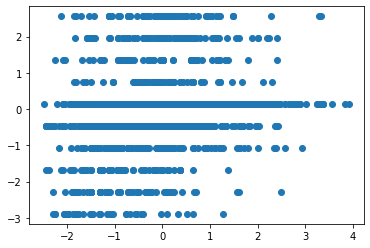


执行梯度下降算法....

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

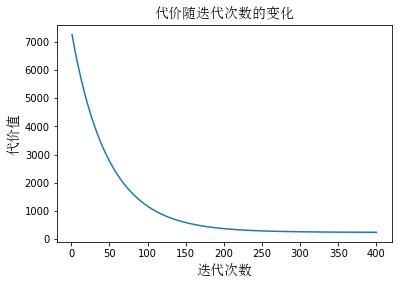


计算的theta值为：
 [[114.10217496]
 [ 18.91980524]
 [  1.89925832]
 [  3.0131603 ]
 [  1.66885904]
 [  1.3767501 ]
 [  0.61130351]
 [  0.63221753]
 [  0.97445355]
 [  5.6201901 ]
 [  3.58890487]
 [  2.14878863]
 [  5.78979909]
 [  2.38981822]
 [ -1.9276595 ]]

预测结果为：
 [[132.20345643]]


In [67]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)    # 解决windows环境下画图汉字乱码问题


def linearRegression(alpha=0.01,num_iters=400):
    print(u"加载数据...\n")
    
    data = loadtxtAndcsv_data("house_test.txt","	",np.float64)  #读取数据
    X = data[:,0:-1]      # X对应0到倒数第2列                  
    y = data[:,-1]        # y对应最后一列  
    m = len(y)            # 总的数据条数
    col = data.shape[1]      # data的列数
    
    X,mu,sigma = featureNormaliza(X)    # 归一化
    plot_X1_X2(X)         # 画图看一下归一化效果
    
    X = np.hstack((np.ones((m,1)),X))    # 在X前加一列1
    
    print(u"\n执行梯度下降算法....\n")
    
    theta = np.zeros((col,1))
    y = y.reshape(-1,1)   #将行向量转化为列
    theta,J_history = gradientDescent(X, y, theta, alpha, num_iters)
    
    plotJ(J_history, num_iters)
    
    return mu,sigma,theta   #返回均值mu,标准差sigma,和学习的结果theta
    
   
    # 加载txt和csv文件
def loadtxtAndcsv_data(fileName,split,dataType):
    return np.loadtxt(fileName,delimiter=split,dtype=dataType)

# # 加载npy文件
# def loadnpy_data(fileName):
#     return np.load(fileName)

# 归一化feature
def featureNormaliza(X):
    X_norm = np.array(X)            #将X转化为numpy数组对象，才可以进行矩阵的运算
    #定义所需变量
    mu = np.zeros((1,X.shape[1]))   
    sigma = np.zeros((1,X.shape[1]))
    
    mu = np.mean(X_norm,0)          # 求每一列的平均值（0指定为列，1代表行）
    sigma = np.std(X_norm,0)        # 求每一列的标准差
    for i in range(X.shape[1]):     # 遍历列
        X_norm[:,i] = (X_norm[:,i]-mu[i])/sigma[i]  # 归一化
    
    return X_norm,mu,sigma

# 画二维图
def plot_X1_X2(X):
    plt.scatter(X[:,0],X[:,1])
    plt.show()


# 梯度下降算法
def gradientDescent(X,y,theta,alpha,num_iters):
    m = len(y)      
    n = len(theta)
    temp = np.matrix(np.zeros((n,num_iters)))   # 暂存每次迭代计算的theta，转化为矩阵形式
    J_history = np.zeros((num_iters,1)) #记录每次迭代计算的代价值
    for i in range(num_iters):  # 遍历迭代次数    
        h = np.dot(X,theta)     # 计算内积，matrix可以直接乘
        temp[:,i] = theta - ((alpha/m)*(np.dot(np.transpose(X),h-y)))   #梯度的计算
        theta = temp[:,i]
        J_history[i] = computerCost(X,y,theta)      #调用计算代价函数
        print('.', end=' ')      
    return theta,J_history  

# 计算代价函数
def computerCost(X,y,theta):
    m = len(y)
    J = 0
    J = (np.transpose(X*theta-y))*(X*theta-y)/(2*m) #计算代价J
    return J

# 画每次迭代代价的变化图
def plotJ(J_history,num_iters):
    x = np.arange(1,num_iters+1)
    plt.plot(x,J_history)
    plt.xlabel(u"迭代次数",fontproperties=font) # 注意指定字体，要不然出现乱码问题
    plt.ylabel(u"代价值",fontproperties=font)
    plt.title(u"代价随迭代次数的变化",fontproperties=font)
    plt.show()

# 测试linearRegression函数
def testLinearRegression():
    mu,sigma,theta = linearRegression(0.01,400)
    print("\n计算的theta值为：\n",theta)
    print(u"\n预测结果为：\n",predict(mu, sigma, theta))
    
# 测试学习效果（预测）
def predict(mu,sigma,theta):
    result = 0
    # 注意归一化
    predict = np.array([105,10,4,0,5,4,4,5,6,1,3,1,1,10])
    norm_predict = (predict-mu)/sigma
    final_predict = np.hstack((np.ones((1)),norm_predict))
    result = np.dot(final_predict,theta)    # 预测结果
    return result
    
    
if __name__ == "__main__":
    testLinearRegression()

In [68]:
# 随机森林

rf = RandomForestRegressor()
rf.fit(x_train,y_train)
print(f'训练集得分：{round(rf.score(x_train,y_train),2)}')
print(f'测试集得分：{round(rf.score(x_test,y_test),2)}')

训练集得分：0.96
测试集得分：0.77


In [69]:
# 决策树
dt = DecisionTreeRegressor(max_depth = 6)
y_pred_dt=dt.fit(x_train,y_train)
print(f'训练集得分：{round(dt.score(x_train,y_train),2)}')
print(f'测试集得分：{round(dt.score(x_test,y_test),2)}')


训练集得分：0.76
测试集得分：0.71


In [70]:
# k近邻

kn = KNeighborsRegressor(n_neighbors=20)
kn.fit(x_train,y_train)
print(f'训练集得分：{round(kn.score(x_train,y_train),2)}')
print(f'测试集得分：{round(kn.score(x_test,y_test),2)}')

训练集得分：0.7
测试集得分：0.7


- 比较几种模型，最终在测试集的得分都能保持在70%以上。
- 随机森林训练集得分达到90%以上，测试集得分在几种模型里表现也是最好的

# 七、实际运用

小明一家需要购房，假设要求如下：
- 3室1厅1卫（3、1、1）
- 面积大概再105㎡左右（105）
- 学区房（1）
- 东南（10）
- 中装修 （4）
- 无电梯 （0）
- 个人产权（5）
- 普通住宅（4）
- 平层（4）
- 钢混（5）
- 城关（6）
- 房龄 （10）
- （105,10,4,0,5,4,4,5,6,1,3,1,1,10）

In [71]:
apply = np.array([105,10,4,0,5,4,4,5,6,1,3,1,1,10]).reshape(1,-1)
poly_apply = poly.fit_transform(apply)
print('------------总价预测结果-------------')
print(f'线性回归：{round(la.predict(poly_apply)[0],2)}万元')
print(f'随机森林回归：{round(rf.predict(poly_apply)[0],2)}万元')
print(f'决策树回归：{round(dt.predict(poly_apply)[0],2)}万元')
print(f'K近邻回归：{round(kn.predict(poly_apply)[0],2)}万元')
print(f'自己手写线性回归：{round(132.20345643,2)}万元')
print('------------综合预测结果-------------')
print(round(((la.predict(poly_apply)+rf.predict(poly_apply)+dt.predict(poly_apply)+kn.predict(poly_apply)+132.20)/5.0)[0],2),'万元')

------------总价预测结果-------------
线性回归：143.71万元
随机森林回归：147.77万元
决策树回归：149.36万元
K近邻回归：152.95万元
自己手写线性回归：132.2万元
------------综合预测结果-------------
145.2 万元
